Source : https://pennylane.ai/qml/demos/tutorial_qaoa_intro.html

In [4]:
import pennylane as qml

## Definition d'un premier circuit hamiltonien avec Pennylane

L'utilisation de circuits en terme Hamiltonien est parfois plus utile qu'en portes logiques. Implémentons ici un premier circuit utilisant les Hamiltoniens.



In [6]:
H = qml.Hamiltonian(
    [1,1,0.5],
    [qml.PauliX(0), qml.PauliZ(1), qml.PauliX(0) @ qml.PauliX(1)]
    
)

print(H)

  (1) [X0]
+ (1) [Z1]
+ (0.5) [X0 X1]


In [8]:
dev = qml.device('default.qubit', wires=2)

t = 1
n = 2

@qml.qnode(dev)

def circuit():
    qml.ApproxTimeEvolution(H, t, n)
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]

print(qml.draw(circuit, expansion_strategy='device')())

0: ──H──────────────MultiRZ(1.00)──H──H─╭MultiRZ(0.50)──H──H──────────────MultiRZ(1.00)──H──H
1: ──MultiRZ(1.00)──H───────────────────╰MultiRZ(0.50)──H──MultiRZ(1.00)──H──────────────────

──╭MultiRZ(0.50)──H─┤  <Z>
──╰MultiRZ(0.50)──H─┤  <Z>


## Utilisation de l'outil de répétition

La répétition de circuit est implémentée dans PennyLane à l’aide de la fonction layer(). Cette méthode nous permet de prendre une fonction contenant soit des opérations quantiques, un modèle, soit même une seule porte quantique, et de l’appliquer à plusieurs reprises à un ensemble de fils.

Par exemple, disons que nous voulons superposer le circuit suivant trois fois:

In [10]:
def circ(theta):
    qml.RX(theta, wires = 0)
    qml.Hadamard(wires = 1)
    qml.CNOT(wires=[0,1])
    
    
@qml.qnode(dev)
def circuit(param):
    circ(param)
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]

print(qml.draw(circuit)(0.5))

0: ──RX(0.50)─╭●─┤  <Z>
1: ──H────────╰X─┤  <Z>


Passons simplement cette fonction dans la fonction layer() :

In [12]:
@qml.qnode(dev)
def circuit(params, **kwargs):
    qml.layer(circ, 3, params)
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]

print(qml.draw(circuit)([0.3, 0.4, 0.5]))

0: ──RX(0.30)─╭●──RX(0.40)─╭●──RX(0.50)─╭●─┤  <Z>
1: ──H────────╰X──H────────╰X──H────────╰X─┤  <Z>


Le circuit a bien été dupliqué !

## QAOA

L’algorithme d’optimisation approximative quantique (QAOA) est une technique générale qui peut être utilisée pour trouver des solutions approximatives aux problèmes d’optimisation combinatoire, en particulier les problèmes qui peuvent être présentés comme la recherche d’une chaîne binaire optimale.

Notre objectif est de trouver la couverture minimale de sommet d’un graphe : une collection de sommets telle que chaque arête du graphe contienne au moins un des sommets de la couverture. Par conséquent, ces sommets « couvrent » toutes les arêtes. Nous souhaitons trouver la couverture de sommet qui a le plus petit nombre possible de sommets.




In [25]:
from pennylane import qaoa
from pennylane import numpy as np
from matplotlib import pyplot as plt
import networkx as nx
from pennylane import device

Définissons également un graphe à quatre sommets pour lequel nous voulons trouver la couverture minimale de sommet:

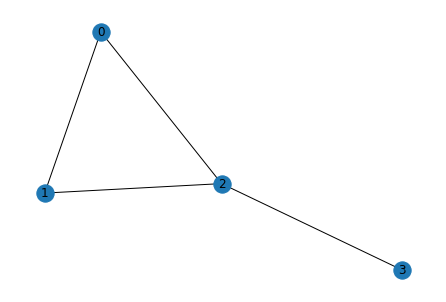

In [26]:
edges = [(0, 1), (1, 2), (2, 0), (2, 3)]
graph = nx.Graph(edges)

nx.draw(graph, with_labels=True)
plt.show()

Nous voyos qu'il existe deux couvertures de sommets minimales de ce graphe : les sommets 0 et 2, et les sommets 1 et 2. Ceux-ci peuvent être représentés respectivement par les chaînes de bits 1010 et 0110 (en numérotant les sommets de 0 à 4 de gauche à droite). Le but de l’algorithme est d’échantillonner ces chaînes de bits avec une forte probabilité.

Le module PennyLane QAOA présente une collection de problèmes d’optimisation intégrés, y compris un couvercle de sommet minimum. Pour chaque problème, vous pouvez récupérer le hamiltonien de coût ainsi qu’un mélangeur hamiltonien recommandé. Cela facilite l’obtention des hamiltoniens pour des problèmes spécifiques tout en permettant la flexibilité de faire d’autres choix, par exemple en ajoutant des contraintes ou en expérimentant avec différents mélangeurs.

Dans notre cas, le coût hamiltonien a deux états fondamentaux, et , coïncidant avec les solutions du problème. L'hamiltonien mélangeur est la somme simple et non commutable des opérations de Pauli-X sur chaque nœud du graphe :


$|1010\rangle|0110\rangle$


In [27]:
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

In [28]:
wires = range(4)
depth = 2

def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])

In [30]:
dev = pennylane.device("qulacs.simulator", wires=wires)

@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(cost_h)

NameError: name 'pennylane' is not defined

In [31]:
optimizer = qml.GradientDescentOptimizer()
steps = 70
params = np.array([[0.5, 0.5], [0.5, 0.5]], requires_grad=True)

In [32]:
for i in range(steps):
    params = optimizer.step(cost_function, params)

print("Optimal Parameters")
print(params)

NameError: name 'cost_function' is not defined

In [33]:
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)


probs = probability_circuit(params[0], params[1])

NameError: name 'cost_h' is not defined